### Imports


In [1]:
import time, math, cv2
import matplotlib.pyplot as plt
import numpy as np
from robolab_turtlebot import Turtlebot, Rate
from TurtleControllers import TurtlebotController

from TurtleUtils import R

%matplotlib inline

### Utils

In [2]:
def show_img(img):
    plt.imshow(img)
    
def apply_mask(img, mask):
    if len(img.shape) == 3:
        img[:,:,0] = np.multiply(img[:,:,0], mask)
        img[:,:,1] = np.multiply(img[:,:,1], mask)
        img[:,:,2] = np.multiply(img[:,:,2], mask)
    elif len(img.shape) == 2:
        img = np.multiply(img, mask)
    else:
        raise Exception(f"Cannot apply mask, image shape: {img.shape}")
    return img
    
def find_regions(mask, minimal_size = 10):
    starts = []
    ends = []
    state = "BLACK"
    for i, n in enumerate(mask):
        if n == 1 and state == "BLACK":
            state = "WHITE"
            starts.append(i)
        elif n == 0 and state == "WHITE":
            state = "BLACK"
            ends.append(i)
    if state == "WHITE":
        ends.append(i+1)
    
    ret = []
    for start,end in zip(starts, ends):
        size = end - start
        if size < minimal_size:
            continue
        ret.append((start, end, end-start))
    
    return ret

### Vision for Turtlebot

In [3]:
class TurtlebotVision:
    def __init__(self, turtle):
        self.turtle = turtle
        
        # Strip parameters
        self.upper_pixel = 100
        self.lower_pixel = 200
        
        # Yellow HSV 
        self.yellow_hsv_lower = np.array([8, 100, 120])
        self.yellow_hsv_upper = np.array([50, 255, 220])
        
        # Purple HSV
        self.purple_hsv_lower = np.array([115, 0, 0])
        self.purple_hsv_upper = np.array([140, 250, 250])

    # ===== Point Cloud =====
    
    def get_pc_image(self):
        return self.turtle.get_point_cloud()
    
    def get_depth_image(self):
        pc_image = self.get_pc_image()
        return np.linalg.norm(pc_image, axis = 2)
    
    def get_depth_image_strip(self):
        depth_image = self.get_depth_image()
        return depth_image[self.upper_pixel:self.lower_pixel]
    
    def get_depth_image_strip_filtered(self):
        depth_image_strip = self.get_depth_image_strip()
        column_mean = np.nanmean(depth_image_strip, axis=0)
        indices = np.where(np.isnan(depth_image_strip))
        depth_image_strip[indices] = np.take(column_mean, indices[1])
        return depth_image_strip
    
    def get_depth_strip(self):
        img = self.get_pc_image()
        return img[self.upper_pixel:self.lower_pixel]
    
    # ===== Garage Detection =====
    def get_garage_points(self):
        pass
    
    # ===== RGB Image =====
    
    def get_rgb_image(self):
        img = self.turtle.get_rgb_image()
        img[:,:,[0,2]] = img[:,:,[2,0]] # BGR → RGB
        return img
    
    def get_rgb_strip(self):
        img = self.get_rgb_image()
        return img[self.upper_pixel:self.lower_pixel]
    
    def get_rgb_strip_mean(self):
        strip = self.get_rgb_strip()
        strip[:] = np.mean(strip, axis = 0)
        return strip
    
    def get_rgb_mask(self, color = "yellow"):
        # Get RGB averaged strip
        rgb_strip_mean = self.get_rgb_strip_mean()
        
        # Convert RGB strip to HSV strip
        hsv_strip = cv2.cvtColor(rgb_strip_mean, cv2.COLOR_RGB2HSV)
        
        # Get HSV color range
        if color.lower() == "yellow":
            hsv_lower = self.yellow_hsv_lower
            hsv_upper = self.yellow_hsv_upper
        elif color.lower() == "purple":
            hsv_lower = self.purple_hsv_lower
            hsv_upper = self.purple_hsv_upper
        else:
            raise Exception(f"Color '{color}' not supported.")
            
        # Detect color, create mask
        mask = cv2.inRange(hsv_strip, hsv_lower, hsv_upper)
        
        # Normalize mask
        if mask.max() != 0:
            mask = mask / mask.max()
            
        return mask
    
    def garage_model(self):
        mask = self.get_rgb_mask(color = "yellow")
        regions = find_regions(mask[0])
        depth_img_strip = self.get_depth_image_strip_filtered()
        points = list()
        
        for start_idx, stop_idx, length in regions:
            STEP = 20
            for i in range(start_idx + 2, stop_idx - 1, 10):
                point = self.make_point(depth_img_strip[0], i)
                
                if point is not None:
                    points.append(point)
        return points
        
    def get_angle(self, array_points, img_width = 640):
        array_points = array_points - img_width // 2
        const_for_cam = 620
        return math.atan(array_points / const_for_cam)
    
    def make_point(self, strip, idx):
        point_in_array = strip[idx]
        
        if math.isnan(point_in_array):
            return None
        
        phi = self.get_angle(idx)
        space_model = np.array([point_in_array * np.cos(phi),
                               -point_in_array * np.sin(phi)])
        return space_model
#end   

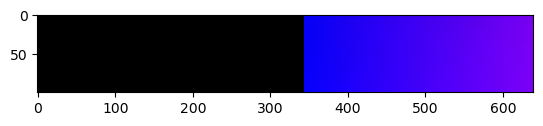

In [4]:
turtle = Turtlebot(rgb = True, pc = True)
turtle_controller = TurtlebotController(turtle, rate = 40)
turtle_vision = TurtlebotVision(turtle)
turtle_controller.reset_odometry()
time.sleep(0.3)
img = turtle_vision.get_depth_strip()
mask = turtle_vision.get_rgb_mask(color = "yellow")
show_img(apply_mask(img, mask))
#show_img(mask)

## Examples

In [2]:
turtle = Turtlebot(rgb = True, pc = True)
turtle_controller = TurtlebotController(turtle, rate = 40)
turtle_vision = TurtlebotVision(turtle)
turtle_controller.reset_odometry()

NameError: name 'TurtlebotVision' is not defined

#### Detect yellow color

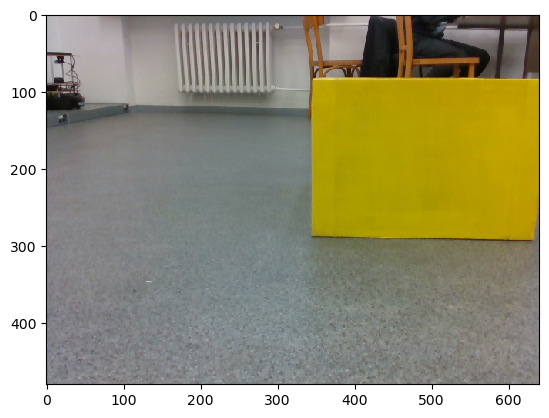

In [6]:
img = turtle_vision.get_rgb_image()
show_img(img)

## Testing

In [7]:
points1 = turtle_vision.garage_model()

/tmp/ipykernel_2586/355098071.py:32: RuntimeWarning: Mean of empty slice
  column_mean = np.nanmean(depth_image_strip, axis=0)


In [17]:
turtle_controller.rotate(0, relative=False)

shutdown request: [/turtlenode] Reason: new node registered with same name


#### Move to second location

In [13]:
pos_diff, angle = turtle_controller.get_odometry()
R_diff = R(angle, degrees = False)

points2 = turtle_vision.garage_model()
points2 = [R_diff @ pt + pos_diff for pt in points2]

In [14]:
points1.extend(points2)

In [8]:
def kuba2icp(points):
    return [np.array([-y, x]) for x,y in points1]

In [9]:
kuba2icp(None)

[array([0.04134162, 0.98583862]),
 array([0.05698615, 0.98142813]),
 array([0.0729436 , 0.98315292]),
 array([0.08849424, 0.97975771]),
 array([0.10393508, 0.97635988]),
 array([0.11889024, 0.96989409]),
 array([0.13392036, 0.96547234]),
 array([0.14912409, 0.9630931 ]),
 array([0.16529822, 0.96683867]),
 array([0.18216515, 0.97364132]),
 array([0.19696952, 0.96921509]),
 array([0.21096043, 0.96173138]),
 array([0.22711185, 0.96444757]),
 array([0.24488897, 0.97327666]),
 array([0.26103997, 0.97496855]),
 array([0.27464361, 0.96749455]),
 array([0.28892443, 0.96308142]),
 array([0.30338618, 0.95969097]),
 array([0.31740211, 0.95528791]),
 array([0.33234091, 0.95394149]),
 array([0.34797891, 0.95463242]),
 array([0.36325347, 0.95430995]),
 array([0.37851918, 0.95399144]),
 array([0.39126023, 0.94758336]),
 array([0.40771859, 0.95032154]),
 array([0.42381469, 0.95204748]),
 array([0.43950015, 0.95276255]),
 array([0.45472657, 0.95246781]),
 array([0.46894518, 0.95015037]),
 array([0.4841

In [ ]:
points2

In [ ]:
points1

In [ ]:
turtle_controller.rotate(-3.0614993044634797, relative=True)

In [ ]:
turtle_controller.move_forward(0.1)

In [3]:
turtle_controller.get_odometry()

(array([0., 0.]), 0.0)

In [ ]:
turtle_controller.reset_odometry()

In [4]:
turtle_controller.move_to(np.array([0.44986718000000003, -0.78412585]))

### **Rotate to find purple points**

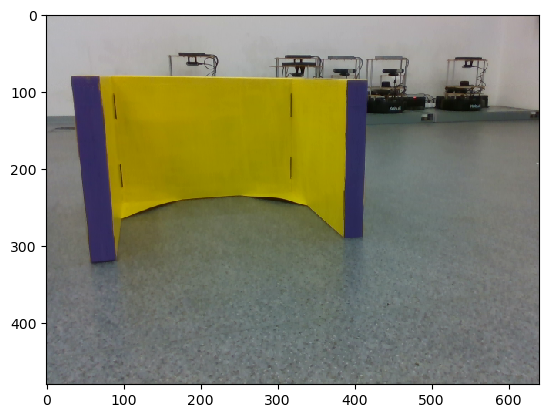

In [16]:
turtle_controller.rotate(0.2, relative = True)

img = turtle_vision.get_rgb_image()
show_img(img)